In [1]:
import pandas as pd
import numpy as np
from detoxify import Detoxify
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from tqdm import tqdm


/home/strrl/Project/7375/assignment1/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("train.csv")

df = df[["comment_text", "toxic"]]

# balance the dataset
df_toxic = df[df["toxic"] == 1].sample(n=5000,random_state=42)
df_non_toxic = df[df["toxic"] == 0].sample(n=5000,random_state=42)

df_sample = pd.concat([df_toxic, df_non_toxic]).sample(frac=1,random_state=42)


In [3]:
# original-small is RoBERTa-small
model = Detoxify('original-small',device='cuda')

2025-06-10 17:54:18.433007: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-10 17:54:18.439221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749603258.446656   48671 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749603258.449243   48671 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749603258.455959   48671 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [4]:
print(model.model.device)

cuda:0


In [5]:
toxic_scores = []
batch_size = 8
texts = df_sample["comment_text"].tolist()

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]
    result = model.predict(batch)
    toxic_scores.extend(result["toxicity"])

df_sample["toxicity_score"] = toxic_scores


100%|██████████| 1250/1250 [00:30<00:00, 40.63it/s]


In [6]:
y_true = df_sample["toxic"].values
y_score = df_sample["toxicity_score"].values
y_pred = (y_score >= 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("AUC:", roc_auc_score(y_true, y_score))

precision, recall, _ = precision_recall_curve(y_true, y_score)
pr_auc = average_precision_score(y_true, y_score)

print("PR AUC:", pr_auc)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5000
           1       0.98      0.92      0.95      5000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

AUC: 0.9937295599999999
PR AUC: 0.9933461476804633


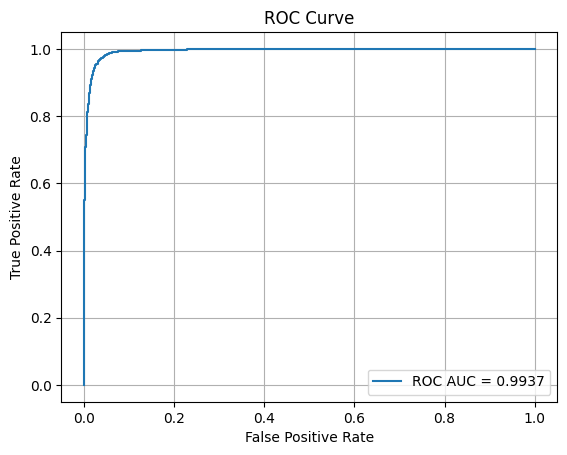

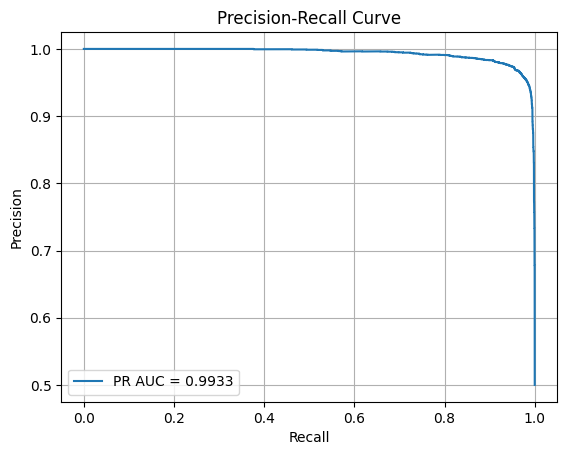

In [7]:
# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_score)
plt.plot(fpr, tpr, label=f"ROC AUC = {auc(fpr, tpr):.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# PR curve
prec, rec, _ = precision_recall_curve(y_true, y_score)
plt.plot(rec, prec, label=f"PR AUC = {auc(rec, prec):.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()